In [1]:
import sys
import os
sys.path.append("../../src")
sys.path.append("../../data")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from IPython import display
import pylab as pl

from CorInfoMaxBSS import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Image Separation'

In [2]:
image_paths = '../../data/TestImages'
images = []
for im_dir in os.listdir(image_paths):
    try:
        images.append(mpimg.imread(os.path.join(image_paths,im_dir)))
    except:
        pass
images = np.array(images)

In [3]:
image_height_and_width = [454, 605]
small_images = np.zeros((images.shape[0],image_height_and_width[0]* image_height_and_width[1]* 3))
small_to_large_image_size_ratio = 0.15
for i in range(images.shape[0]):
    small_img = cv2.resize(images[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=small_to_large_image_size_ratio, 
                           fy=small_to_large_image_size_ratio, 
                           interpolation=cv2.INTER_NEAREST)
    print(small_img.shape)
    if small_img.shape[0] == 486:
        small_img = cv2.resize(small_img, (0,0), fx = 454/486, fy = 605/648)

    small_images[i] = small_img.reshape(-1,)/255

small_images.shape

(454, 605, 3)
(486, 648, 3)
(486, 648, 3)
(486, 648, 3)
(454, 605, 3)
(454, 605, 3)
(486, 648, 3)
(454, 605, 3)
(454, 605, 3)
(486, 648, 3)
(486, 648, 3)
(454, 605, 3)
(454, 605, 3)
(486, 648, 3)


(14, 824010)

In [4]:
images_indexes = np.random.choice(np.arange(14), 3, replace = False)

In [5]:
images_indexes

array([ 5, 11,  7])

<IPython.core.display.Math object>

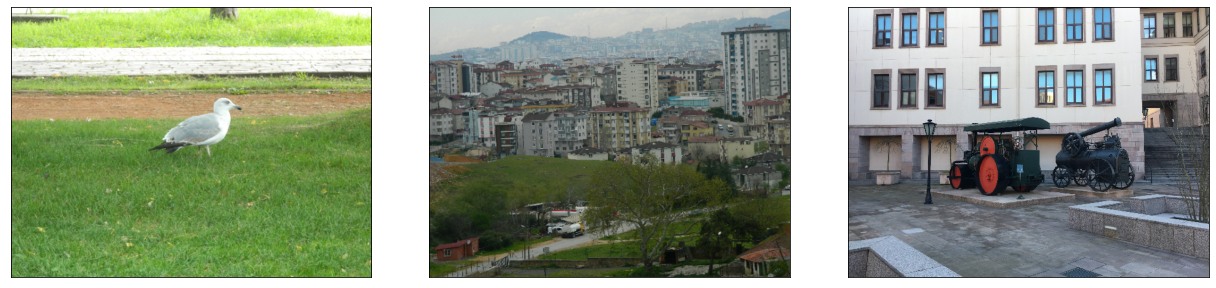

In [6]:
images_indexes = np.random.choice(np.arange(14), 3, replace = False)
images_indexes = [13, 1, 12]
S = small_images[images_indexes]
Subplot_RGB_images(S, imsize = image_height_and_width, height = 4, width = 18)
display_matrix(np.corrcoef(S))
# plt.savefig('Original_Images.pdf', format = 'pdf', dpi = 1500)

In [7]:
np.random.seed(250)
NumberofMixtures = 5
NumberofSources = 3

A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)
SNR = 40

X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

X_ = ZeroOneNormalizeColumns(X.T).T
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

print("Row standard deviation of mixtures : {}".format(X.std(1)))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 39.99431219228776
Row standard deviation of mixtures : [0.32352984 0.36408713 0.34490649 0.25310507 0.26272439]


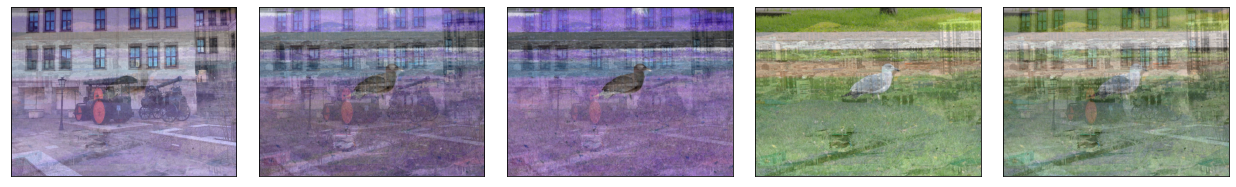

In [8]:
Subplot_RGB_images(X_, imsize = image_height_and_width, height = 3, width = 18)
# plt.savefig('Mixture_Images.pdf', format = 'pdf', dpi = 1500)

In [9]:
# subplot_1D_signals(S[:,1000:1200], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

In [10]:
# plt.figure()
# plt.scatter(S[0,:], S[1,:])
# plt.figure()
# plt.scatter(S[1,:], S[2,:])
# plt.figure()
# plt.scatter(S[0,:], S[2,:])

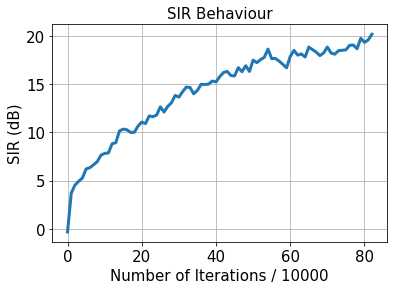

100%|██████████| 824010/824010 [12:48<00:00, 1072.43it/s]


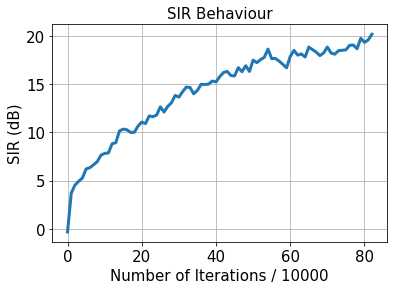

In [11]:
lambday = 1 - 1e-1/50
lambdae = 0.5

s_dim = S.shape[0]
x_dim = X.shape[0]

n_samples = X.shape[1]
n_iter = n_samples
ppf = X.shape[1]
Wf_arr = []

# Inverse output covariance
By = 1 * np.eye(s_dim)
# Inverse error covariance
Be = 650 * np.eye(s_dim)

debug_iteration_point = 10000
model = CorInfoMaxVideoSeparation(  s_dim = s_dim, x_dim = x_dim, muW = 215*1e-3, lambday = lambday,
                                    lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                                    set_ground_truth = True, S = S, A = A)

_ = model.seperate_videos( Wf_list = Wf_arr, n_pixel_per_frame = ppf, X = X.reshape(1,NumberofMixtures, -1), 
                           n_iter = n_iter, neural_dynamic_iterations = 500,
                           plot_in_jupyter = True, neural_lr_start = 0.75,
                           neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                           shuffle = True)

In [12]:
Wf = -1*model.compute_overall_mapping(return_mapping = True)
OverallMatrix = Wf @ A
perm = np.argmax(OverallMatrix, axis = 0)
Y = (Wf @ X)[perm]
Y = ZeroOneNormalizeColumns(Y.T).T
PSNR_levels = []
for kk in range(S.shape[0]):
    PSNR_levels.append(psnr(S[kk], Y[kk]))

SINR = 10*np.log10(CalculateSINRjit(Y, S, False)[0])
print("Component PSNR Values : {}\n".format(PSNR_levels))
print("Overall SINR : {}".format(SINR))

Component PSNR Values : [24.88500726352754, 24.061063117143643, 34.675445455932206]

Overall SINR : 28.60531942892119


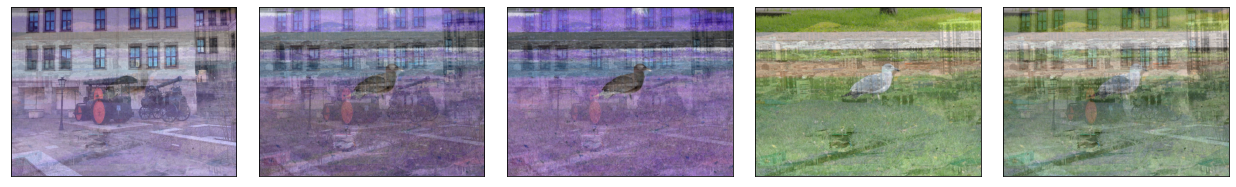

In [13]:
Subplot_RGB_images(X_, imsize = image_height_and_width, height = 3, width = 18)

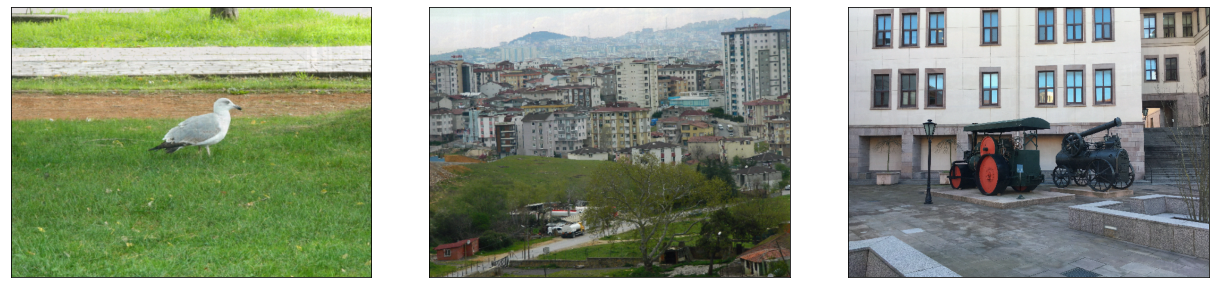

In [14]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y.T).T, imsize = image_height_and_width, height = 4, width = 18)
# plt.savefig('deneme.pdf', format = 'pdf', dpi = 1500)

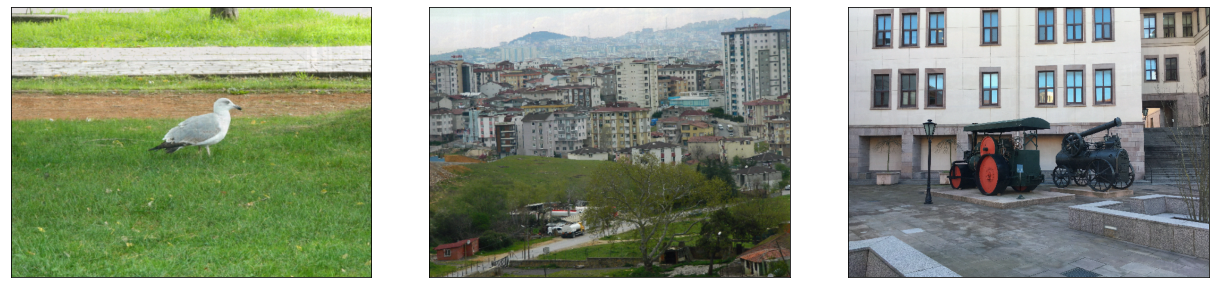

In [15]:
Subplot_RGB_images(np.clip(Y, 0,1), imsize = image_height_and_width, height = 4, width = 18)

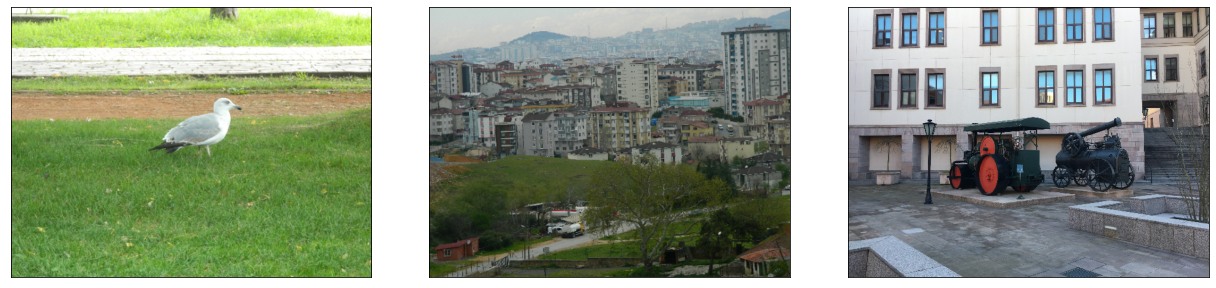

In [16]:
Subplot_RGB_images(S, imsize = image_height_and_width, height = 4, width = 18)